<a href="https://colab.research.google.com/github/FendyDeveloper/Bank-Transaction-Dataset-for-Fraud-Detection/blob/main/%5BKlasifikasi%5D_Submission_Akhir_BMLP_Fendy_Rahmat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [26]:
# Memuat dataset dari file CSV
df = pd.read_csv('data_cluster.csv')

# Menampilkan beberapa baris pertama dari dataset
df.head()

,TransactionAmount,TransactionType,Location,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,DaysBetweenTransaction,Cluster
0,14.09,Debit,San Diego,ATM,70.0,Doctor,81.0,1.0,5112.21,572.0,0
1,376.24,Debit,Houston,ATM,68.0,Doctor,141.0,1.0,13758.91,495.0,0
2,126.29,Debit,Mesa,Online,19.0,Student,56.0,1.0,1122.35,482.0,1
3,184.50,Debit,Raleigh,Online,26.0,Student,25.0,1.0,8569.06,548.0,1
4,13.45,Credit,Atlanta,Online,26.0,Student,198.0,1.0,7429.40,384.0,1


In [27]:
df.describe()

,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance,DaysBetweenTransaction,Cluster
count,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000
mean,297.593778,44.673965,119.643312,1.124602,5114.302966,486.857882,0.270303
std,291.946243,17.792198,69.963757,0.602662,3900.942499,106.378910,0.444204
min,0.260000,18.000000,10.000000,1.000000,101.250000,307.000000,0.000000
25%,81.885000,27.000000,63.000000,1.000000,1504.370000,394.000000,0.000000
50%,211.140000,45.000000,112.500000,1.000000,4735.510000,485.000000,0.000000
75%,414.527500,59.000000,161.000000,1.000000,7678.820000,580.000000,1.000000
max,1919.110000,80.000000,300.000000,5.000000,14977.990000,671.000000,1.000000


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   TransactionAmount       2512 non-null   float64
 1   TransactionType         2512 non-null   object 
 2   Location                2512 non-null   object 
 3   Channel                 2512 non-null   object 
 4   CustomerAge             2512 non-null   float64
 5   CustomerOccupation      2512 non-null   object 
 6   TransactionDuration     2512 non-null   float64
 7   LoginAttempts           2512 non-null   float64
 8   AccountBalance          2512 non-null   float64
 9   DaysBetweenTransaction  2512 non-null   float64
 10  Cluster                 2512 non-null   int64  
dtypes: float64(6), int64(1), object(4)
memory usage: 216.0+ KB


In [29]:
# Simpan objek LabelEncoder dan scaler
encoders = {}
scalers = {}

categorical_features = ['TransactionType', 'Location', 'Channel', 'CustomerOccupation',]

for column in categorical_features:
    le = LabelEncoder()
    scaler = StandardScaler()
    df[column] = le.fit_transform(df[column])
    df[column] = scaler.fit_transform(df[[column]])
    encoders[column] = le
    scalers[column] = scaler


scaler = StandardScaler()

# Analisis distribusi variabel numerik
numerical_features = ['TransactionAmount', 'CustomerAge', 'TransactionDuration',
                     'LoginAttempts', 'AccountBalance', 'DaysBetweenTransaction']

# Normaliasasi data numerik
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [30]:
df.head()

,TransactionAmount,TransactionType,Location,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,DaysBetweenTransaction,Cluster
0,-0.971275,0.540538,1.231735,-1.225361,1.423718,-1.337394,-0.552443,-0.206794,-0.000537,0.800526,0
1,0.269440,0.540538,-0.515085,-1.225361,1.311287,-1.337394,0.305314,-0.206794,2.216472,0.076554,0
2,-0.586882,0.540538,0.150370,1.247014,-1.443277,1.319064,-0.909842,-0.206794,-1.023534,-0.045675,1
3,-0.387456,0.540538,0.982189,1.247014,-1.049768,1.319064,-1.353017,-0.206794,0.885797,0.574872,1
4,-0.973468,-1.850010,-1.596450,1.247014,-1.049768,1.319064,1.120184,-0.206794,0.593589,-0.967094,1


# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [31]:
X = df.drop('Cluster', axis=1)
y = df['Cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
X_train

,TransactionAmount,TransactionType,Location,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,DaysBetweenTransaction
1626,-0.957092,0.540538,0.399916,-1.225361,0.636700,-0.451908,-1.310129,-0.206794,0.848143,0.988571
1313,0.124624,0.540538,-0.598267,0.010826,0.411837,-1.337394,-1.067098,-0.206794,0.031552,0.988571
942,0.509771,0.540538,-0.515085,-1.225361,1.030209,0.433578,-0.609627,-0.206794,0.704918,-1.503021
1770,-1.013312,0.540538,1.314917,1.247014,1.985874,0.433578,-0.852658,-0.206794,0.117197,0.781721
1984,4.163911,0.540538,0.732643,1.247014,-1.443277,1.319064,-0.995618,-0.206794,1.243303,-0.318340
...,...,...,...,...,...,...,...,...,...,...
1638,-0.579653,0.540538,1.564462,-1.225361,1.367503,0.433578,-1.267241,-0.206794,-0.641938,1.007375
1095,-0.945649,0.540538,1.314917,-1.225361,0.524269,0.433578,-0.695403,-0.206794,0.634121,-1.061116
1130,-0.988097,0.540538,1.314917,1.247014,-1.274631,1.319064,0.291018,-0.206794,-1.083796,-0.008066
1294,-0.706482,0.540538,-0.348722,-1.225361,1.142640,0.433578,0.848561,-0.206794,-0.695284,0.875744


In [33]:
X_test

,TransactionAmount,TransactionType,Location,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,DaysBetweenTransaction
2081,-0.248362,0.540538,-1.346905,-1.225361,-0.937337,1.319064,-1.210057,-0.206794,-0.914472,-1.493619
433,-0.727141,0.540538,1.730826,-1.225361,1.198856,0.433578,0.662713,-0.206794,-0.753953,0.001336
1724,-0.963807,0.540538,-1.596450,-1.225361,0.692915,-1.337394,-1.081394,-0.206794,1.501735,1.336453
1251,-0.691408,0.540538,-1.596450,1.247014,-1.274631,1.319064,-1.324425,-0.206794,-1.241656,0.979168
93,0.495143,0.540538,-0.099176,1.247014,-1.443277,1.319064,2.006534,-0.206794,-0.958550,-1.587641
...,...,...,...,...,...,...,...,...,...,...
1703,3.416433,-1.850010,1.730826,0.010826,0.018328,-0.451908,2.278157,-0.206794,1.234165,-1.493619
289,-0.852634,0.540538,1.647644,0.010826,-1.330846,1.319064,-1.467385,-0.206794,-1.102062,-0.807256
1619,-0.845166,-1.850010,-0.348722,1.247014,-0.937337,1.319064,0.433978,-0.206794,-0.983702,0.678297
2252,-0.209066,0.540538,1.065371,-1.225361,1.929659,0.433578,-0.109268,-0.206794,-0.416786,-0.543993


# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih.

In [34]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [35]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [36]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

### Algoritma yang Digunakan
Dalam proyek ini, kami menggunakan tiga algoritma machine learning, yaitu:
- Random Forest (RF): Algoritma ensemble learning yang efektif untuk menangani dataset besar dan kompleks.
- Logistic Regression (LR): Algoritma supervised learning yang efektif untuk menangani dataset dengan banyak fitur yang tidak relevan.
- K-Nearest Neighbors (KNN): Algoritma supervised learning yang efektif untuk menangani dataset dengan banyak fitur yang tidak relevan.

Ketiga algoritma ini dipilih karena kelebihan dan kelemahan yang berbeda, sehingga dapat memberikan hasil prediksi yang akurat dan efektif.

## **b. Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah.

In [37]:
y_pred_rf = rf.predict(X_test)
print("Random Forest - Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest - F1-Score:", f1_score(y_test, y_pred_rf, average='weighted'))

Random Forest - Accuracy: 0.9960238568588469
Random Forest - F1-Score: 0.9960138939512031


In [38]:
y_pred_lr = lr.predict(X_test)
print("Logistic Regression - Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression - F1-Score:", f1_score(y_test, y_pred_lr, average='weighted'))

Logistic Regression - Accuracy: 0.9980119284294234
Logistic Regression - F1-Score: 0.9980094541394182


In [39]:
knn_pred = knn.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, knn_pred))
print("KNN F1 Score: {knn_f1}", f1_score(y_test, knn_pred, average='weighted'))

KNN Accuracy: 0.9920477137176938
KNN F1 Score: {knn_f1} 0.9920073308851447


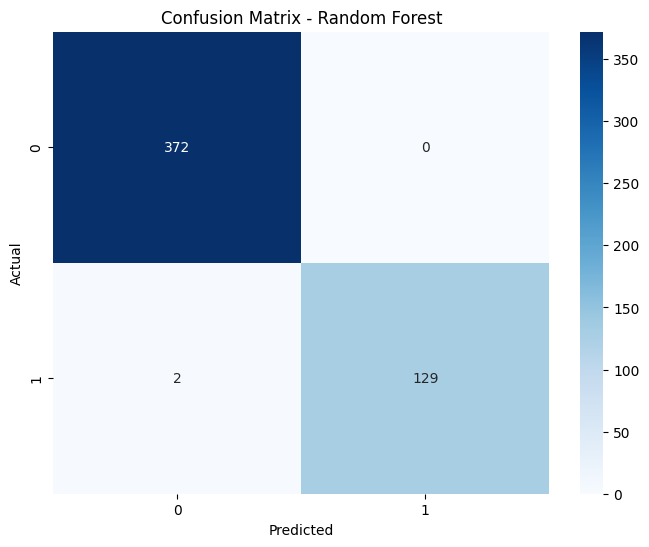

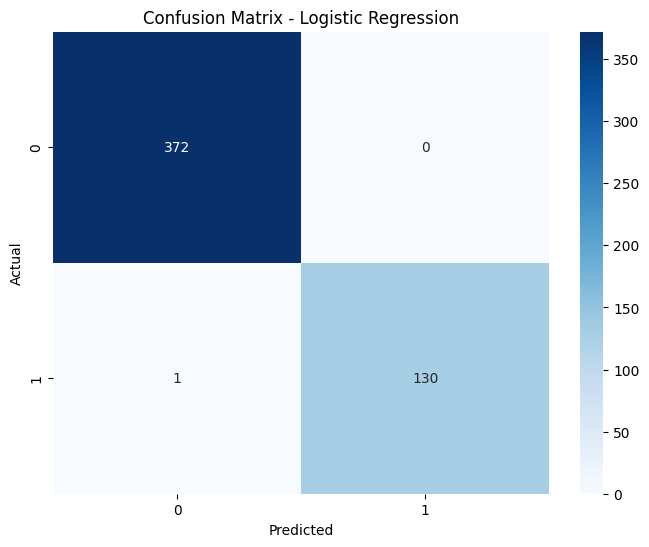

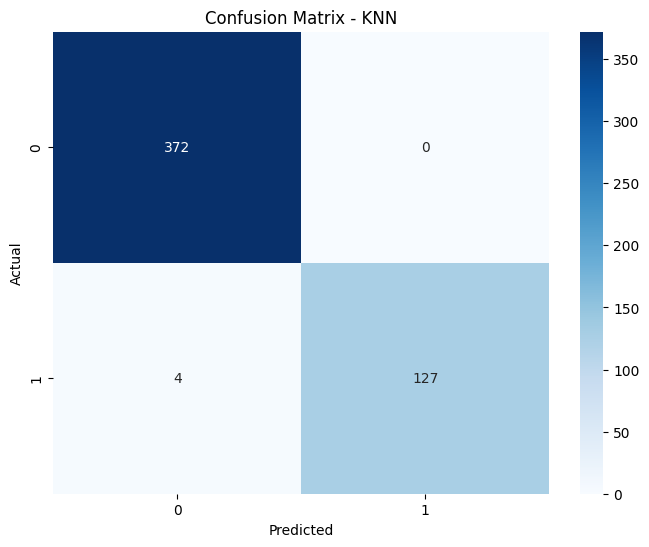

In [40]:
# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Predict using other models and create confusion matrices similarly
y_pred_lr = lr.predict(X_test)
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

y_pred_knn = knn.predict(X_test)
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - KNN")
lt.show()

Random Forest:
- Akurasi (Accuracy): 99.6%
- F1-Score: 99.60%

Logistic Regression:
- Akurasi (Accuracy): 99.8%
- F1-Score: 99.8%

KNN:
- Akurasi (Accuracy): 99.2%
- F1-Score: 99.2%


Model Random Forest Anda menunjukkan hasil yang sangat baik, dengan akurasi dan F1-Score yang sangat tinggi. Model Logistic Regression juga menunjukkan hasil yang baik, tetapi tidak sebaik model Random Forest. Model KNN masih menunjukkan hasil yang kurang baik.

## **c. Tuning Model Klasifikasi (Optional)**

Gunakan GridSearchCV, RandomizedSearchCV, atau metode lainnya untuk mencari kombinasi hyperparameter terbaik

In [41]:
# Definisikan parameter grid untuk hyperparameter tuning
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

# Buat instance model Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Buat instance GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='f1_weighted')

# Jalankan proses tuning hyperparameter
grid_search_rf.fit(X_train, y_train)

# Cetak hasil tuning hyperparameter
print("Hyperparameter terbaik:", grid_search_rf.best_params_)
print("Nilai F1-score terbaik:", grid_search_rf.best_score_)

Hyperparameter terbaik: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Nilai F1-score terbaik: 0.9929872571286454


## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa.

In [42]:
# Buat instance model Random Forest dengan hyperparameter terbaik
from sklearn.ensemble import RandomForestClassifier
best_rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)

# Jalankan proses training model
best_rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [43]:
# Prediksi label untuk data testing
y_pred = best_rf_model.predict(X_test)

# Hitung metrik evaluasi
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

print("F1-score:", f1_score(y_test, y_pred, average='weighted'))
print("Akurasi:", accuracy_score(y_test, y_pred))
print("Laporan klasifikasi:\n", classification_report(y_test, y_pred))
print("Matriks konfusi:\n", confusion_matrix(y_test, y_pred))

F1-score: 0.9960138939512031
Akurasi: 0.9960238568588469
Laporan klasifikasi:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       372
           1       1.00      0.98      0.99       131

    accuracy                           1.00       503
   macro avg       1.00      0.99      0.99       503
weighted avg       1.00      1.00      1.00       503

Matriks konfusi:
 [[372   0]
 [  2 129]]


## **e. Analisis Hasil Evaluasi Model Klasifikasi**


Analisis Hasil Evaluasi Model Klasifikasi

1. Performa Model

    Model Random Forest menunjukkan performa yang sangat baik dalam mengklasifikasikan data. F1-score dan akurasi yang sangat tinggi (0,996) menunjukkan bahwa model berhasil memprediksi kelas sampel dengan sangat akurat. Confusion Matrix juga menunjukkan bahwa model berhasil memprediksi 501 dari 503 sampel dengan benar.
